In [2]:
# Imports
import scipy.io as sio
from scipy import stats
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
from sklearn import datasets
import scipy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import h5py
import random
import utils
import csv
import json
from keras import applications
from keras.layers import Input
from keras.models import Model
import pandas as pd

sys.path.append("../") # go to parent dir
from mrcode.utils.file_utils import fileFinder, folderFinder

c:\users\dea\anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data

In [2]:
def std_windows(eeg, time_window = 50):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        temp_eeg.append(np.std(temp_epoch.reshape(int(temp_epoch.shape[0]/time_window),time_window,temp_epoch.shape[1]),1).flatten())
    std_eeg = np.array(temp_eeg)
    return std_eeg

def std_overlap_windows(eeg, time_window = 80, overlap = 0.5):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        std_channels = []
        for jj in range(temp_epoch.shape[1]):
            channel = temp_epoch[:,jj]

            std_channel = []
            for kk in range(int(time_window*overlap)):
                std_channel.append(channel[kk:(kk+time_window)])

            std_channels.append(np.std(std_channel,1))

        temp_eeg.append(std_channels)
        
    temp_eeg_array = np.array(temp_eeg)
    std_temp_eeg = temp_eeg_array.reshape(temp_eeg_array.shape[0],temp_eeg_array.shape[2]*temp_eeg_array.shape[1])
    return std_temp_eeg

def load_data(ii,data_path,feature = 'raw'):
    data = sio.loadmat(data_path + '/' + ii + '/eeg_events.mat')
    eeg = data['eeg_events'].transpose()
    
    if feature == 'raw':
        eeg = eeg.reshape(eeg.shape[0],eeg.shape[2]*eeg.shape[1])
        # normalizing data
        #eeg = np.arcsinh(eeg*1000)
    
    if feature == 'std':
        eeg = std_windows(eeg)
        
    if feature == 'std_overlap':
        eeg = std_overlap_windows(eeg)
    
    data_image = sio.loadmat(data_path + '/' + ii + '/image_semantics.mat')
    image_semantics = data_image['image_semantics'].transpose()
    image_info = pd.read_csv(data_path + '/' + ii + '/image_order.txt', delimiter='\t', dtype=object)
    return eeg, image_semantics, image_info

In [3]:
data_path = '../data/experiment_data'
experiment_folders = folderFinder(data_path)
X_temp = []
Y_temp = []
imageids = []
target = 'image_id'
loadmode = 'raw'
for count_sources, ii in enumerate(experiment_folders):
    
    # first time
    if count_sources == 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = eeg
        Y_temp = image_semantics
        imageids = list(image_info[target].as_matrix())
        
    # after first load
    elif count_sources > 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = np.vstack((X_temp,eeg))
        Y_temp = np.vstack((Y_temp,image_semantics))
        imageids = np.hstack((imageids,list(image_info[target].as_matrix())))

## DO NOT RUN Making data ready

In [25]:
# Normalize
xScale = StandardScaler().fit(X_temp) 
X_temp = xScale.transform(X_temp)

# Making split for train, validation and test
test_split = range(20,690*len(experiment_folders),30)

# Prepare target data
Y_test = Y_temp[test_split,:]
Y_train = np.delete(Y_temp,test_split,0)

# Prepare input data
X_test = X_temp[test_split,:]
X_train = np.delete(X_temp,test_split,0)

# Printing shape of data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(10005, 17600)
(10005, 2048)
(345, 17600)
(345, 2048)


In [ ]:
# Prepare imageids
imageids_test = imageids[test_split]
imageids_train = np.delete(imageids,test_split,0)
print(imageids_test.shape)
print(imageids_train.shape)

## Making data ready by collecting a random test set

In [5]:
# Normalize
xScale = StandardScaler().fit(X_temp) 
X_temp = xScale.transform(X_temp)

#### Make test set

In [10]:
# Making a new test set where the same image is not included more times

X_test = []
imageids_test = []
test_split = []
count = 0
valid = False
for i in range(23*len(experiment_folders)):
    while (valid == False):
        r = random.choice(range(count,count+30))
        if imageids[r] not in imageids_test:
            imageids_test.append(imageids[r])
            X_test.append(X_temp[r])
            test_split.append(r)
            valid = True
        
    count += 30
    valid = False
    
# Lav til np array
test_split = np.array(test_split)

X_test = np.array(X_test)
imageids_test = np.array(imageids_test)

In [11]:
# Creating rest of test sets
Y_test = Y_temp[test_split,:]

# Create the training sets
X_train = np.delete(X_temp, test_split,0)
Y_train = np.delete(Y_temp,test_split,0)
imageids_train = np.array(np.delete(imageids, test_split,0))

In [12]:
# Printing shape of data
print(X_train.shape)
print(Y_train.shape)
print(imageids_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(imageids_test.shape)

(10005, 17600)
(10005, 2048)
(10005,)
(345, 17600)
(345, 2048)
(345,)


## DO NOT RUN THIS - Saving datasets

In [ ]:
#np.save('../data/pred_image_semantics/X_train',X_train)
#np.save('../data/pred_image_semantics/Y_train',Y_train)
#np.save('../data/pred_image_semantics/imageids_train',imageids_train)
#np.save('../data/pred_image_semantics/X_test',X_test)
#np.save('../data/pred_image_semantics/Y_test',Y_test)
#np.save('../data/pred_image_semantics/imageids_test',imageids_test)
#np.save('../data/pred_image_semantics/test_split',test_split)

#### Make validation set

In [15]:
X_val = []
imageids_val = []
val_split = []
count = 0
valid = False
for i in range(23*len(experiment_folders)):
    while (valid == False):
        r = random.choice(range(count,count+29))
        if imageids[r] not in imageids_val:
            imageids_val.append(imageids[r])
            X_val.append(X_train[r])
            val_split.append(r)
            valid = True
        
    count += 29
    valid = False
    
# Lav til np array
val_split = np.array(val_split)

X_val = np.array(X_val)
imageids_val = np.array(imageids_val)

In [19]:
# Creating rest of test sets
Y_val = Y_train[val_split,:]

# Create the training set
X_trainVal = np.delete(X_train, val_split,0)
Y_trainVal = np.delete(Y_train,val_split,0)
imageids_trainVal = np.array(np.delete(imageids_train, val_split,0))

In [20]:
# Printing shape of data
print(X_trainVal.shape)
print(Y_trainVal.shape)
print(imageids_trainVal.shape)
print(X_test.shape)
print(Y_test.shape)
print(imageids_test.shape)
print(X_val.shape)
print(Y_val.shape)
print(imageids_val.shape)

(9660, 17600)
(9660, 2048)
(9660,)
(345, 17600)
(345, 2048)
(345,)
(345, 17600)
(345, 2048)
(345,)


## DO NOT RUN THIS - Saving datasets

In [21]:
#np.save('../data/pred_image_semantics/X_trainVal',X_trainVal)
#np.save('../data/pred_image_semantics/Y_trainVal',Y_trainVal)
#np.save('../data/pred_image_semantics/imageids_trainVal',imageids_trainVal)
# Saving validation set
#np.save('../data/pred_image_semantics/X_val',X_val)
#np.save('../data/pred_image_semantics/Y_val',Y_val)
#np.save('../data/pred_image_semantics/imageids_val',imageids_val)
#np.save('../data/pred_image_semantics/val_split',val_split)

## Loading datasets

In [3]:
X_train = np.load('../data/pred_image_semantics/X_trainVal.npy')
Y_train = np.load('../data/pred_image_semantics/Y_trainVal.npy')
imageids_train = np.load('../data/pred_image_semantics/imageids_trainVal.npy')
X_test = np.load('../data/pred_image_semantics/X_test.npy')
Y_test = np.load('../data/pred_image_semantics/Y_test.npy')
imageids_test = np.load('../data/pred_image_semantics/imageids_test.npy')
X_val = np.load('../data/pred_image_semantics/X_val.npy')
Y_val = np.load('../data/pred_image_semantics/Y_val.npy')
imageids_val = np.load('../data/pred_image_semantics/imageids_val.npy')

## Ridge regression

In [4]:
alpha = 10000

# Finding the variance of the test set to use as comparison for baseline
E_nul_values = np.var(Y_test, 0)
Y_testt = np.transpose(Y_test)

# Making the regression
clf = Ridge(alpha, fit_intercept = True)
clf.fit(X_train, Y_train)

# Fitting the values
Y_pred = clf.predict(X_test)

# Changing negative values to 0
Y_pred_nonneg = []
for i in Y_pred:
    new_imsem = []
    for j in i:
        if j < 0:
            new_imsem.append(0)
        else:
            new_imsem.append(j)
    Y_pred_nonneg.append(new_imsem)
    
Y_pred_nonneg = np.asarray(Y_pred_nonneg)

# Saving the overall MSE
MSE = mean_squared_error(Y_test,Y_pred_nonneg)
MSE_norm = MSE/np.mean(E_nul_values)
print('MSE ' + str(MSE)) 
print('Normalized MSE ' + str(MSE_norm)) 
Y_predt = np.transpose(Y_pred_nonneg)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt)):
    e = mean_squared_error(Y_testt[i], Y_predt[i])
    E_values.append(e)
    
# Calculating the E delta (E/E_0)
E_delta = np.divide(E_values,E_nul_values)

# Checking how many values are smaller than 1
lower = sum(E_delta < 1)
print('Number of E_delta values lower than 1: ' + str(lower))

MSE 0.0908916808990719
Normalized MSE 1.0238326233254036
Number of E_delta values lower than 1: 264


In [9]:
Y_pred_nonneg.shape

(345, 2048)

In [10]:
np.argmin(E_delta)

1749

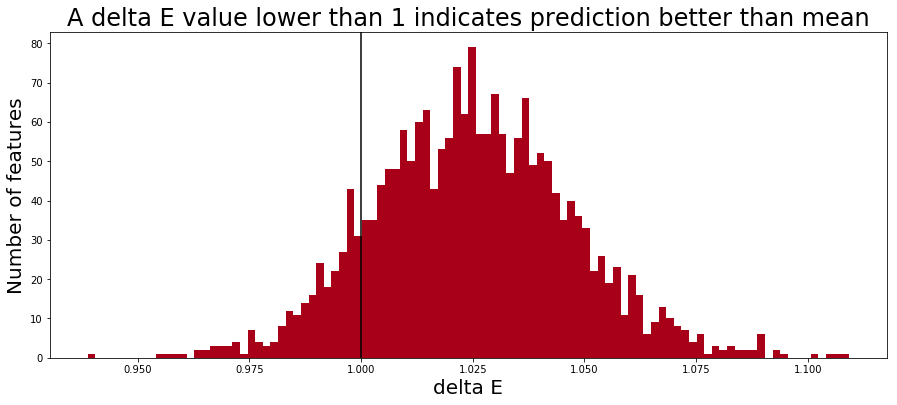

In [11]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.axvline(x=1, color = 'black')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 24)
plt.xlabel('delta E', fontsize = 20)
plt.ylabel('Number of features', fontsize = 20)
plt.savefig('predictableFeatures.eps', format='eps', dpi=1000)
plt.show()

In [5]:
map_predictable = []

for i in range(len(E_delta)):
    if E_delta[i] < 1:
        map_predictable.append(True)
    else:
        map_predictable.append(False)
        
map_predictable = np.array(map_predictable)

In [6]:
map_predictable

array([False, False, False, ...,  True, False, False])

In [14]:
#np.save('../data/pred_image_semantics/map_predictable', map_predictable)

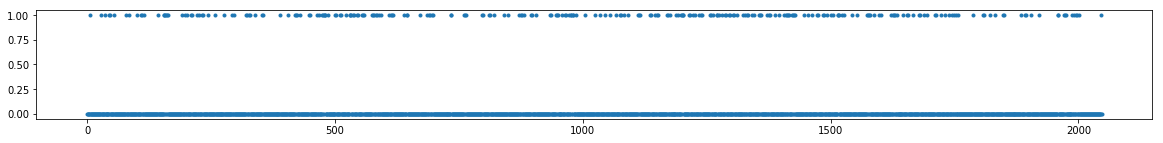

In [7]:
plt.figure(figsize=(20,2))
plt.plot(map_predictable,'.')

In [16]:
Y_pred_new = []
Y_test_new = []
for i in range(len(Y_pred_nonneg)):
    Y_pred_new.append(Y_pred_nonneg[i][map_predictable])
    Y_test_new.append(Y_test[i][map_predictable])

In [17]:
len(Y_pred[0][map_predictable])

264

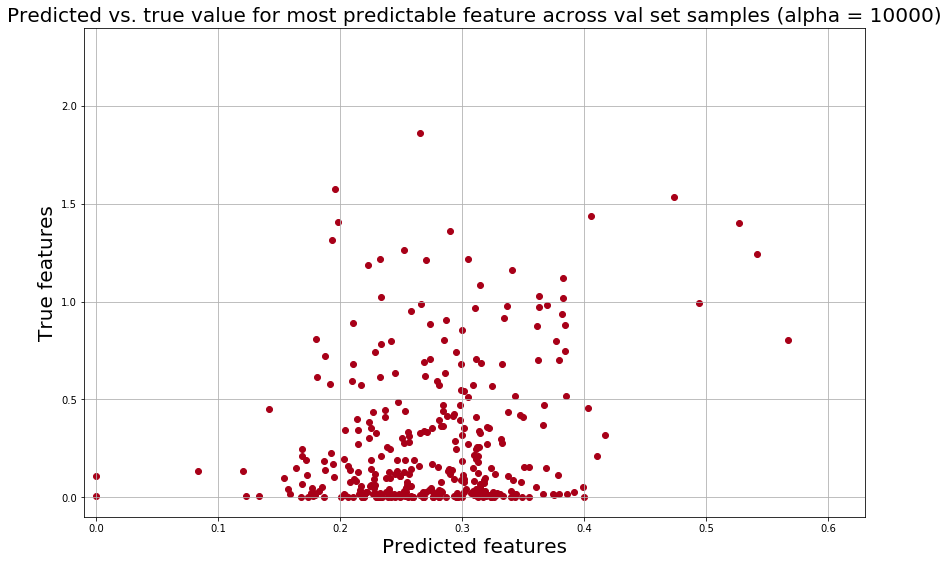

In [78]:
# Plotting true vs target
plt.figure(figsize=(14,9))
plt.scatter(Y_pred_nonneg.transpose()[1749], Y_test.transpose()[1749], color = '#a80018')
plt.xlabel('Predicted features', fontsize = 20)
plt.ylabel('True features', fontsize = 20)
plt.ylim(ymax = 2.4)
plt.xlim(xmax = 0.63)
plt.xlim(xmin = -0.01)
plt.title('Predicted vs. true value for most predictable feature across val set samples (alpha = 10000)', fontsize = 20)
plt.grid()
plt.savefig('most_predictable_feature_alpha10000.eps', format='eps', dpi=1000)

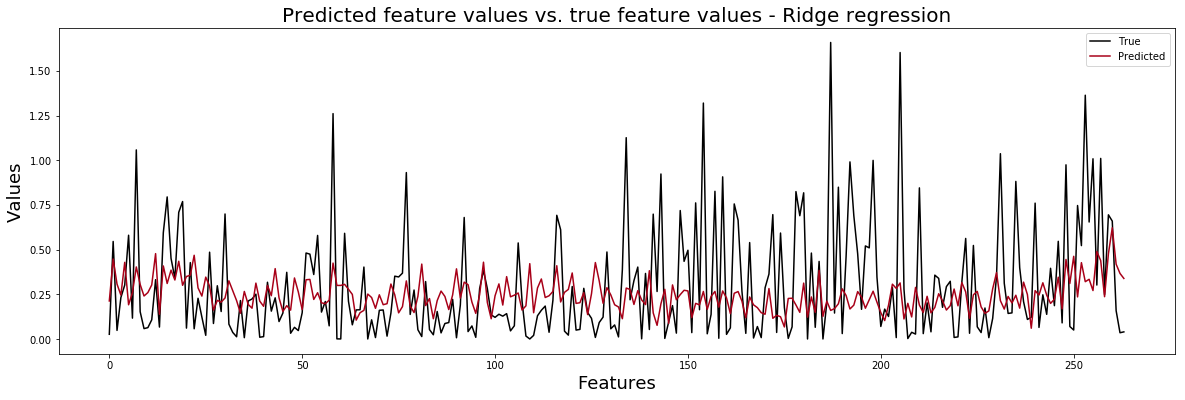

In [19]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
image = 200
plt.plot(range(len(Y_test_new[image])), Y_test_new[image], color = 'black')
plt.plot(range(len(Y_test_new[image])), Y_pred_new[image], color = '#a80018')
plt.title('Predicted feature values vs. true feature values - Ridge regression', fontsize = 20)
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Values', fontsize = 18)
plt.legend(['True', 'Predicted'])
plt.show()

## Creating Y_pred_nonneg as h5 file

In [20]:
Y_pred_nonneg

array([[0.43267379, 0.3204766 , 0.26686443, ..., 0.37154098, 0.35645399,
        0.42577839],
       [0.32241584, 0.29201316, 0.2332681 , ..., 0.31060372, 0.28743614,
        0.38831544],
       [0.28902587, 0.29765684, 0.29604782, ..., 0.3503088 , 0.32698913,
        0.35995019],
       ...,
       [0.26756648, 0.31368808, 0.28398421, ..., 0.38507915, 0.36706665,
        0.40523951],
       [0.3158232 , 0.24131571, 0.24386756, ..., 0.30984856, 0.32982635,
        0.38614631],
       [0.32663495, 0.26622022, 0.22879078, ..., 0.35820306, 0.35275886,
        0.44993412]])

In [21]:
# Creates a h5 file
f = h5py.File('../data/pred_image_semantics/pred_ridge' + '.h5', 'a')

# adds data to the file
for i in range(len(Y_pred_nonneg)):
    f["%s" % imageids_test[i]] = Y_pred_nonneg[i]
    
# Close the file
f.close()

## Making a vector of mean values across features - size 2048

In [4]:
Y_train.shape

(9660, 2048)

In [5]:
mean_feature_vector = np.mean(Y_train,0)

In [6]:
mean_feature_vector.shape

(2048,)

In [7]:
np.save('mean_feature_vector', mean_feature_vector)

## Creating Y_pred_new of the features where delta E < 1

In [57]:
# Using mean of all the features for that image
Y_pred_mean = []
for i in Y_pred_nonneg:
    new_imsem = []
    for j in range(len(i)):
        if map_predictable[j] == True:
            new_imsem.append(i[j])     
        else:
            mean = np.mean(i)
            new_imsem.append(mean)
    Y_pred_mean.append(new_imsem)
    
Y_pred_mean = np.asarray(Y_pred_mean)

In [65]:
# Using mean of train set across features
Y_pred_mean = []
for i in Y_pred_nonneg:
    new_imsem = []
    for j in range(len(i)):
        if map_predictable[j] == True:
            new_imsem.append(i[j])     
        else:
            new_imsem.append(mean_feature_vector[j])
    Y_pred_mean.append(new_imsem)
    
Y_pred_mean = np.asarray(Y_pred_mean)

In [66]:
Y_pred_mean.shape

(345, 2048)

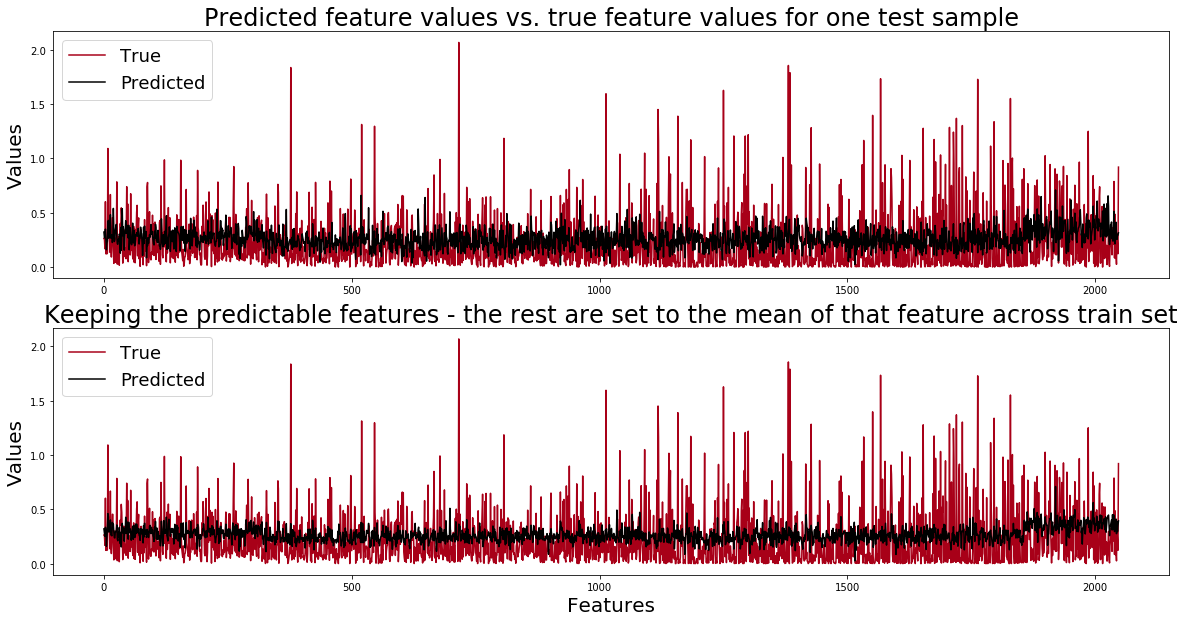

In [70]:
# Plotting true and pred against each other
plt.figure(figsize=(20,10))
plt.title('Predicted feature values vs. true feature values for one test sample', fontsize = 24)
image = 300
plt.subplot(211)
plt.plot(range(len(Y_test[image])), Y_test[image], color = '#a80018')
plt.plot(range(len(Y_pred_nonneg[image])), Y_pred_nonneg[image], color = 'black')
plt.title('Predicted feature values vs. true feature values for one test sample', fontsize = 24)
plt.ylabel('Values', fontsize = 20)
plt.legend(['True', 'Predicted'], fontsize = 18)
plt.subplot(212)
plt.plot(range(len(Y_test[image])), Y_test[image], color = '#a80018')
plt.plot(range(len(Y_pred_mean[image])), Y_pred_mean[image], color = 'black')
plt.title('Keeping the predictable features - the rest are set to the mean of that feature across train set', fontsize = 24)
plt.ylabel('Values', fontsize = 20)
plt.xlabel('Features', fontsize = 20)
plt.legend(['True', 'Predicted'], fontsize = 18)
plt.savefig('predictableFeatures_onesample_mean.eps', format='eps', dpi=1000)
plt.show()

## Saving Y_pred to a h5 file

In [62]:
# Creates a h5 file
f = h5py.File('../data/pred_image_semantics/pred_ridge_mean + '.h5', 'a')

# adds data to the file
for i in range(len(Y_pred_mean)):
    f["%s" % imageids_test[i]] = Y_pred_mean[i]
    
# Close the file
f.close()

In [63]:
# Read the file
hf = h5py.File('../data/pred_image_semantics/pred_ridge_mean.h5', 'r')
keys = list(hf.keys())
len(keys)

345

In [81]:
hf.close()

### Make the random set

In [86]:
for k in range(10):
    print('Creating pred_ridge_mean_random_' + str(k))
    random_list = np.random.choice([0, 1], size=(2048,), p=[0.87109375, 0.12890625])
    
    Y_pred_mean_random = []
    for i in Y_pred_nonneg:
        new_imsem = []
        for j in range(len(i)):
            if random_list[j] == 1:
                new_imsem.append(i[j])     
            else:
                new_imsem.append(mean_feature_vector[j])
        Y_pred_mean_random.append(new_imsem)

    Y_pred_mean_random = np.asarray(Y_pred_mean_random)
    
    # Saving the fil
    # Creates a h5 file
    f = h5py.File('../data/pred_image_semantics/pred_ridge_mean_random_' + str(k) + '.h5', 'a')

    # adds data to the file
    for l in range(len(Y_pred_mean_random)):
        f["%s" % imageids_test[l]] = Y_pred_mean_random[l]

    # Close the file
    f.close()

Creating pred_ridge_mean_random_0
Creating pred_ridge_mean_random_1
Creating pred_ridge_mean_random_2
Creating pred_ridge_mean_random_3
Creating pred_ridge_mean_random_4
Creating pred_ridge_mean_random_5
Creating pred_ridge_mean_random_6
Creating pred_ridge_mean_random_7
Creating pred_ridge_mean_random_8
Creating pred_ridge_mean_random_9


## Make true image semantics with only the predictable features 

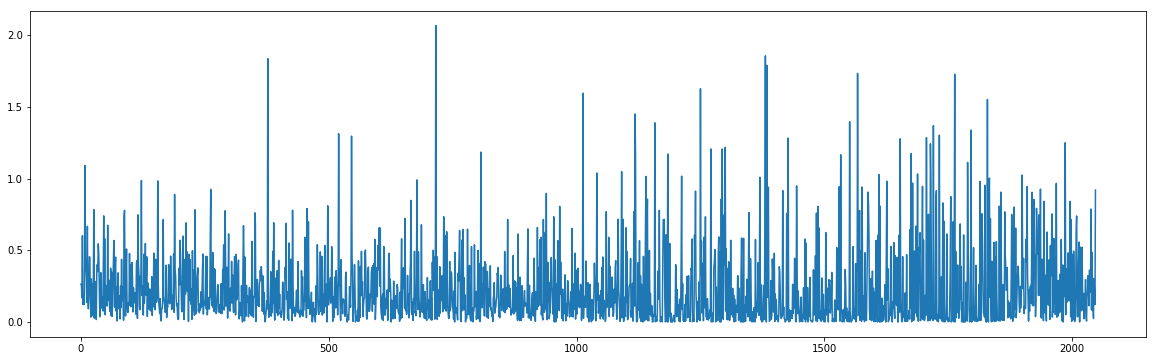

In [71]:
plt.figure(figsize=(20,6))
plt.plot(range(2048), Y_test[300])
plt.show()

#### Saving full features

In [72]:
# Creates a h5 file
f = h5py.File('../data/pred_image_semantics/test_ridge' + '.h5', 'a')

# adds data to the file
for i in range(len(Y_test)):
    f["%s" % imageids_test[i]] = Y_test[i]
    
# Close the file
f.close()

In [73]:
# Using mean of train set across features
image_semantics_mean = []
for i in Y_test:
    new_imsem = []
    for j in range(len(i)):
        if map_predictable[j] == True:
            new_imsem.append(i[j])     
        else:
            new_imsem.append(mean_feature_vector[j])
    image_semantics_mean.append(new_imsem)
    
image_semantics_mean = np.asarray(image_semantics_mean)
image_semantics_mean.shape

(345, 2048)

In [83]:
# using mean across single image
image_semantics_mean = []
for i in Y_test:
    new_imsem = []
    for j in range(len(i)):
        if map_predictable[j] == True:
            new_imsem.append(i[j])     
        else:
            mean = np.mean(i)
            new_imsem.append(mean)
    image_semantics_mean.append(new_imsem)
    
image_semantics_mean = np.asarray(image_semantics_mean)
image_semantics_mean.shape

(345, 2048)

#### Saving mean features

In [84]:
# Creates a h5 file
f = h5py.File('../data/pred_image_semantics/test_ridge_mean' + '.h5', 'a')

# adds data to the file
for i in range(len(image_semantics_mean)):
    f["%s" % imageids_test[i]] = image_semantics_mean[i]
    
# Close the file
f.close()

### Make the random sets

In [80]:
random_list = np.random.choice([0, 1], size=(2048,), p=[0.87109375, 0.12890625])

In [85]:
for k in range(10):
    print('Creating test_ridge_mean_random_' + str(k))
    
    random_list = np.random.choice([0, 1], size=(2048,), p=[0.87109375, 0.12890625])
    
    # RANDOM
    image_semantics_mean_random = []
    for i in Y_test:
        new_imsem = []
        for j in range(len(i)):
            if random_list[j] == 1:
                new_imsem.append(i[j])     
            else:
                mean = np.mean(i)
                new_imsem.append(mean)
        image_semantics_mean_random.append(new_imsem)

    image_semantics_mean_random = np.asarray(image_semantics_mean_random)
    
    # Creates a h5 file
    f = h5py.File('../data/pred_image_semantics/test_ridge_mean_random_' + str(k) + '.h5', 'a')

    # adds data to the file
    for l in range(len(image_semantics_mean_random)):
        f["%s" % imageids_test[l]] = image_semantics_mean_random[l]

    # Close the file
    f.close()

Creating test_ridge_mean_random_0
Creating test_ridge_mean_random_1
Creating test_ridge_mean_random_2
Creating test_ridge_mean_random_3
Creating test_ridge_mean_random_4
Creating test_ridge_mean_random_5
Creating test_ridge_mean_random_6
Creating test_ridge_mean_random_7
Creating test_ridge_mean_random_8
Creating test_ridge_mean_random_9


# Ridge regression with validation set

In [24]:
# Loop over all test set n = 30

alpha = 10000

# Finding the variance of the test set to use as comparison for baseline
E_nul_values = np.var(Y_val, 0)
Y_valt = np.transpose(Y_val)

# Making the regression
#clf = Ridge(alpha)
#clf.fit(X_train, Y_train)

# Fitting the values
Y_pred = clf.predict(X_val)

# Changing negative values to 0
Y_pred_nonneg = []
for i in Y_pred:
    new_imsem = []
    for j in i:
        if j < 0:
            new_imsem.append(0)
        else:
            new_imsem.append(j)
    Y_pred_nonneg.append(new_imsem)
    
Y_pred_nonneg = np.asarray(Y_pred_nonneg)

# Saving the overall MSE
MSE = mean_squared_error(Y_val,Y_pred_nonneg)
MSE_norm = MSE/np.mean(E_nul_values)
print('MSE ' + str(MSE)) 
print('Normalized MSE ' + str(MSE_norm)) 

Y_predt = np.transpose(Y_pred_nonneg)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt)):
    e = mean_squared_error(Y_valt[i], Y_predt[i])
    E_values.append(e)
    
# Calculating the E delta (E/E_0)
E_delta = np.divide(E_values,E_nul_values)

# Checking how many values are smaller than 1
lower = sum(E_delta < 1)
print('Number of E_delta values lower than 1: ' + str(lower))

MSE 0.09426523417839222
Normalized MSE 1.0442921837802546
Number of E_delta values lower than 1: 101


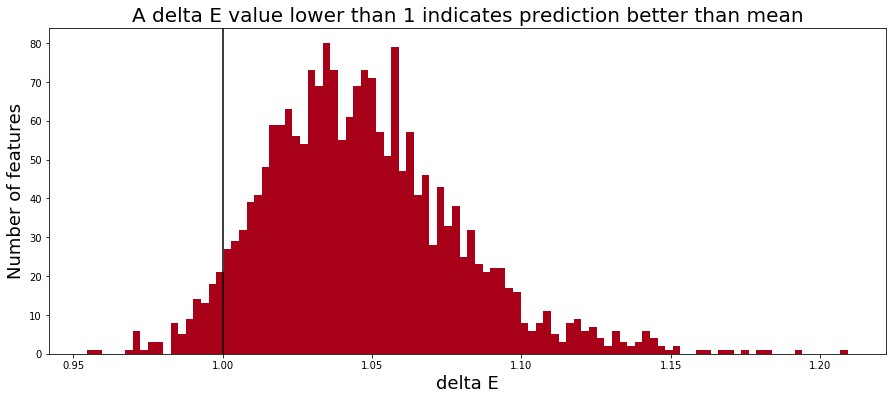

In [23]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.axvline(x=1, color = 'black')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

In [9]:
map_predictable_val = []

for i in range(len(E_delta)):
    if E_delta[i] < 1:
        map_predictable_val.append(True)
    else:
        map_predictable_val.append(False)
        
map_predictable_val = np.array(map_predictable_val)

In [10]:
map_predictable_val

array([False, False, False, ..., False, False, False])

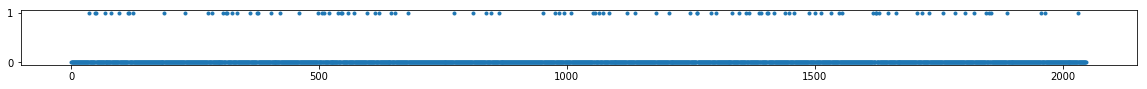

In [11]:
plt.figure(figsize=(20,1))
plt.plot(map_predictable_val,'.')

In [12]:
map_combined = []
for i in range(len(map_predictable)):
    if (map_predictable[i] == True) & (map_predictable_val[i] == True):
        map_combined.append(map_predictable[i])
    else:
        map_combined.append(False)

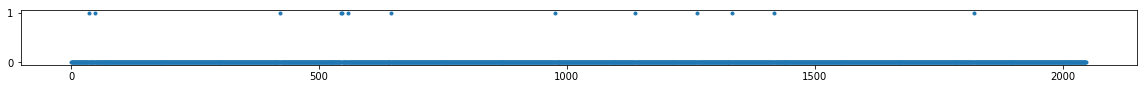

In [13]:
plt.figure(figsize=(20,1))
plt.plot(map_combined,'.')

In [14]:
# Cheking how many of the same features can be predicted for test and validation set
count = 0
for i in range(len(map_predictable_val)):
    if (map_predictable[i] == True) & (map_predictable_val[i] == True):
        count += 1
        
print('Number of features shared between validation set and test set that can be predicted: ' + str(count))

Number of features shared between validation set and test set that can be predicted: 13


In [23]:
((101/2048)*(264/2048))*100

0.6357192993164062

## Saving true and predicted to matlab

In [24]:
#Getting pred and true to matlab for making representational similarity plot 
sio.savemat('image_semantics_ridge_pred.mat', {'image_semantics_Y_pred':Y_pred_nonneg})
sio.savemat('image_semantics_ridge_true.mat', {'image_semantics_Y_test':Y_test})

In [90]:
sio.savemat('delta_E.mat', {'delta_E':E_delta})

In [33]:
sio.savemat('image_semantics_ridge_pred_alpha.mat', {'image_semantics_Y_pred_alpha':Y_pred_nonneg})